<a href="https://colab.research.google.com/github/Daniellien2018/Project_4_AllLife_Bank_Customer_Segmentation/blob/main/Daniel_Lien_Full_Code_AIML_USL_Project_CreditCardCustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

### Context


AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


###  Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing necessary libraries and data

In [ ]:
#data manipulation
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

#k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load data, check
path = '/content/drive/My Drive/UT Austin AIML/Datasets/Credit+Card+Customer+Data.xlsx'
credit_card_data = pd.read_excel(path)
data = credit_card_data.copy()
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


## Data Overview

- Observations
- Sanity checks

### Observations


In [ ]:
#check shape of dataset
data.shape

(660, 7)

In [ ]:
#check head of data
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [ ]:
#check tail of data
data.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


In [ ]:
#check data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [ ]:
#customer key column is erroneous, fix to Customer_Key to keep consistent
data.columns = [c.replace(" ", "_") for c in data.columns]

### Sanity Checks

In [ ]:
#check for missing values
data.isnull().sum()

Sl_No                  0
Customer_Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [ ]:
#check number of unique values in columns
data.nunique()

Sl_No                  660
Customer_Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

In [ ]:
#check for duplicate values
data_grouped = data.groupby("Customer_Key").count()

for i in data_grouped.loc[data_grouped.Sl_No >= 2].index:
  display(data.loc[data.Customer_Key == i])

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


In [ ]:
#drop sl_no column, not useful
data.drop(columns=["Sl_No"], inplace=True)


In [ ]:
data.head()

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,87073,100000,2,1,1,0
1,38414,50000,3,0,10,9
2,17341,50000,7,1,3,4
3,40496,30000,5,1,1,4
4,47437,100000,6,0,12,3


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.5,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.0,10.0


## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Functions for EDA


In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Univariate Analysis

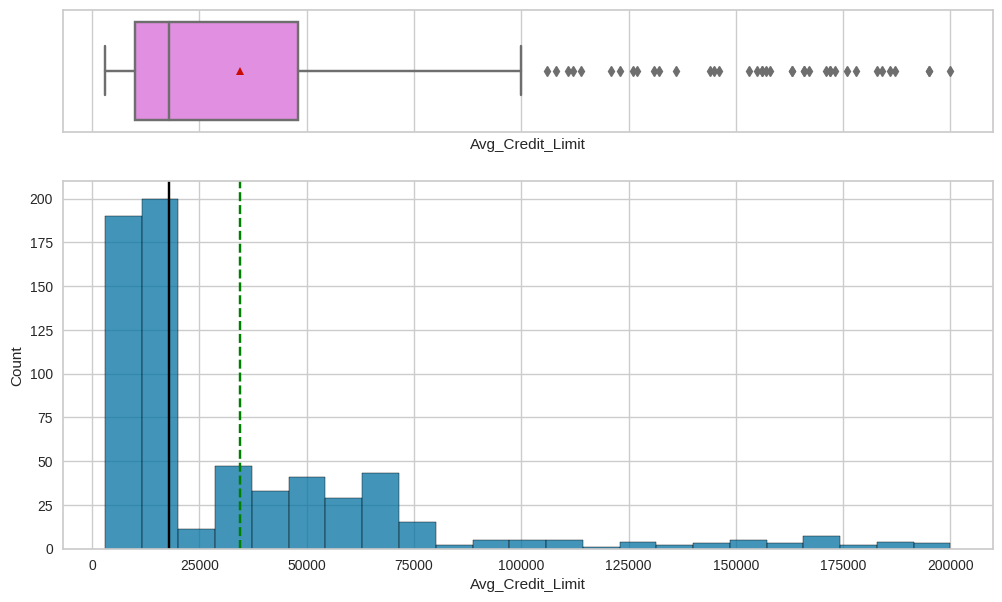

In [ ]:
#histogram_boxplot for Avg_Credit_Limit
histogram_boxplot(data, "Avg_Credit_Limit")



*   The Average Credit Limit was around $18,000, and the distribution was extremely skewed to the right



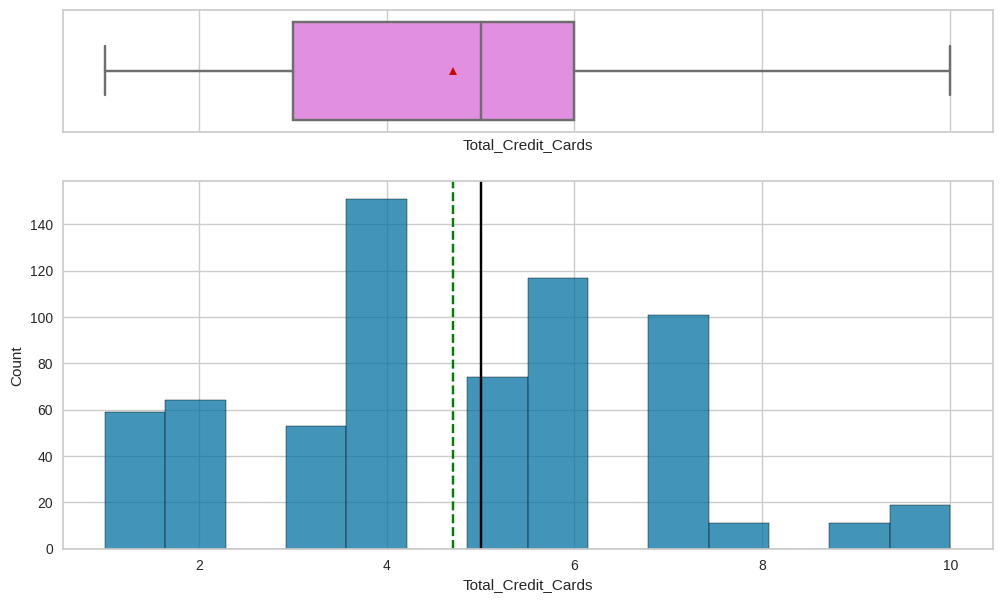

In [ ]:
#histogram_boxplot for Total_Credit_Cards
histogram_boxplot(data, "Total_Credit_Cards")



*   The average number of credit cards was 5 cards, with the max being 10 and the min being 1.
*   Distribition was fairly even with the mode being 4 cards






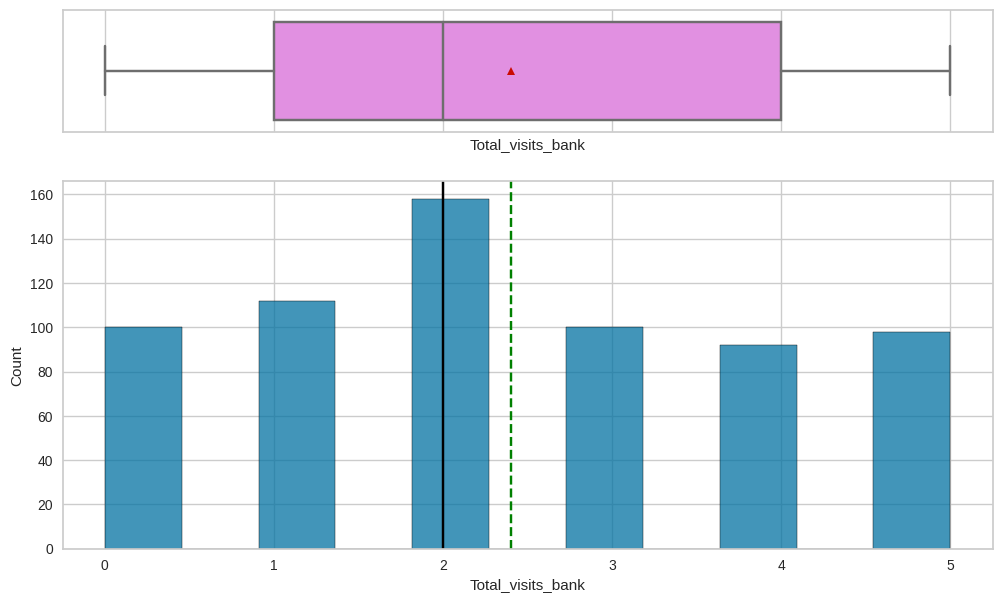

In [ ]:
#histogram_boxplot for Total_visits_bank
histogram_boxplot(data, "Total_visits_bank")

*   The average number of total bank visits was around 2.5, with the max being 5 and min being 0
*   The distribution was fairly even, with the mode being 2 as well



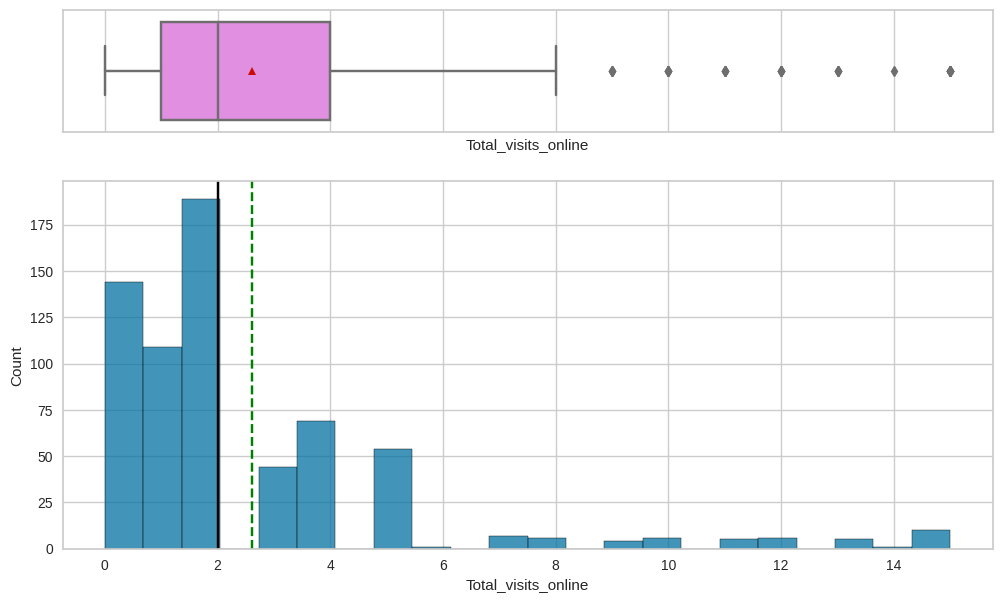

In [ ]:
#histogram_boxplot for Total_visits_online
histogram_boxplot(data, "Total_visits_online")

*   The average number of total online visits was around 2.5, with the max being 15 and the min 0
*   The distribution was skewed to the right, with the majority of total online visit being less or equal to 2



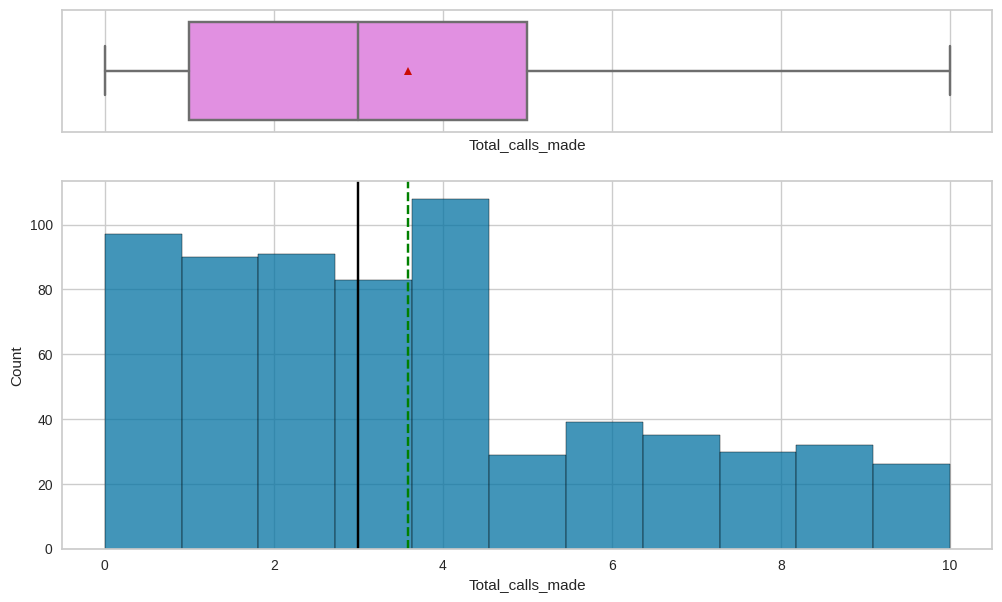

In [ ]:
#histogram_boxplot for Total_calls_made
histogram_boxplot(data, "Total_calls_made")

*   The average for total calls made was around 3.5, with the max being 10 and min being 0
*   The distribution was slightly skewed to the right.



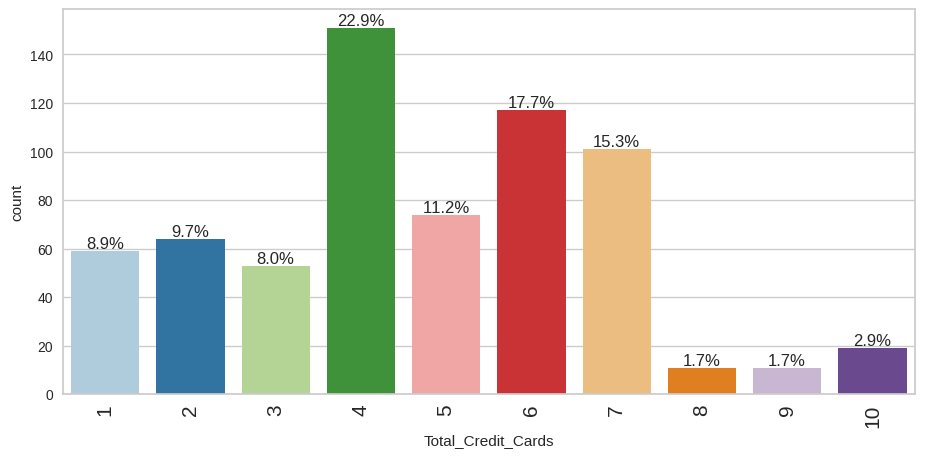

In [ ]:
#bar plot for credit cards
labeled_barplot(data, "Total_Credit_Cards", perc=True)


*   The most common number of total credit cards was 4



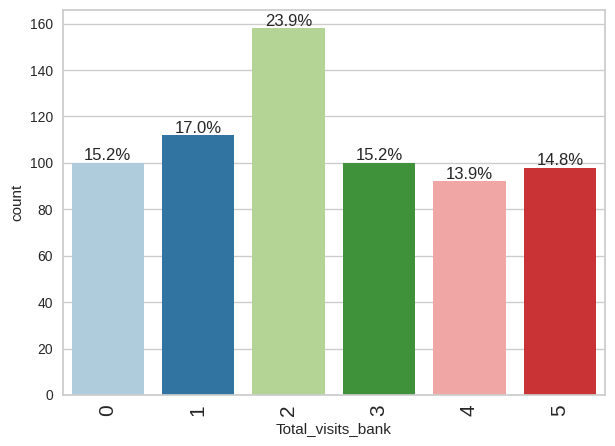

In [ ]:
#bar plot for Total_visits_bank
labeled_barplot(data, "Total_visits_bank", perc=True)



*   The most common number of total bank visits was 2
*   Distribution was fairly even





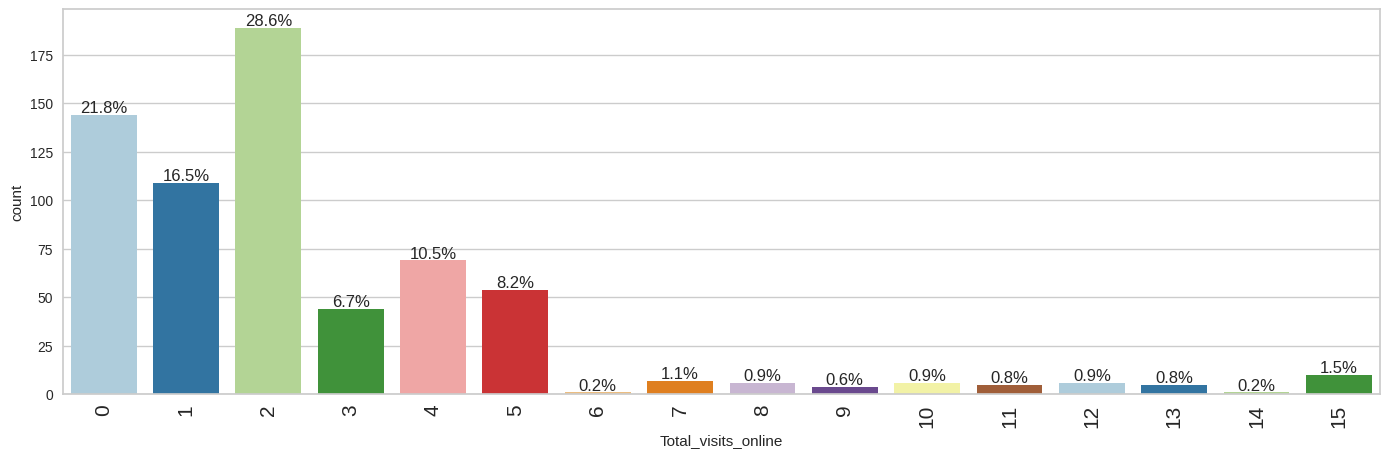

In [ ]:
#bar plot for Total_visits_online
labeled_barplot(data, "Total_visits_online", perc=True)



*   The most common number of online visits was 2
*   The distibution was slightly skewed right.



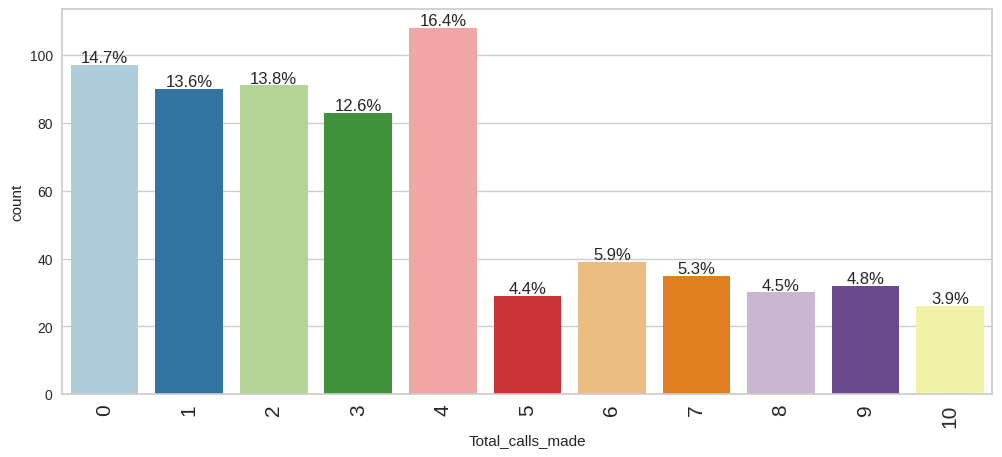

In [ ]:
#bar plot for Total_calls_made
labeled_barplot(data, "Total_calls_made", perc=True)



*  The most common number of calls made was 4
*   The distribution was very slightly skewed right



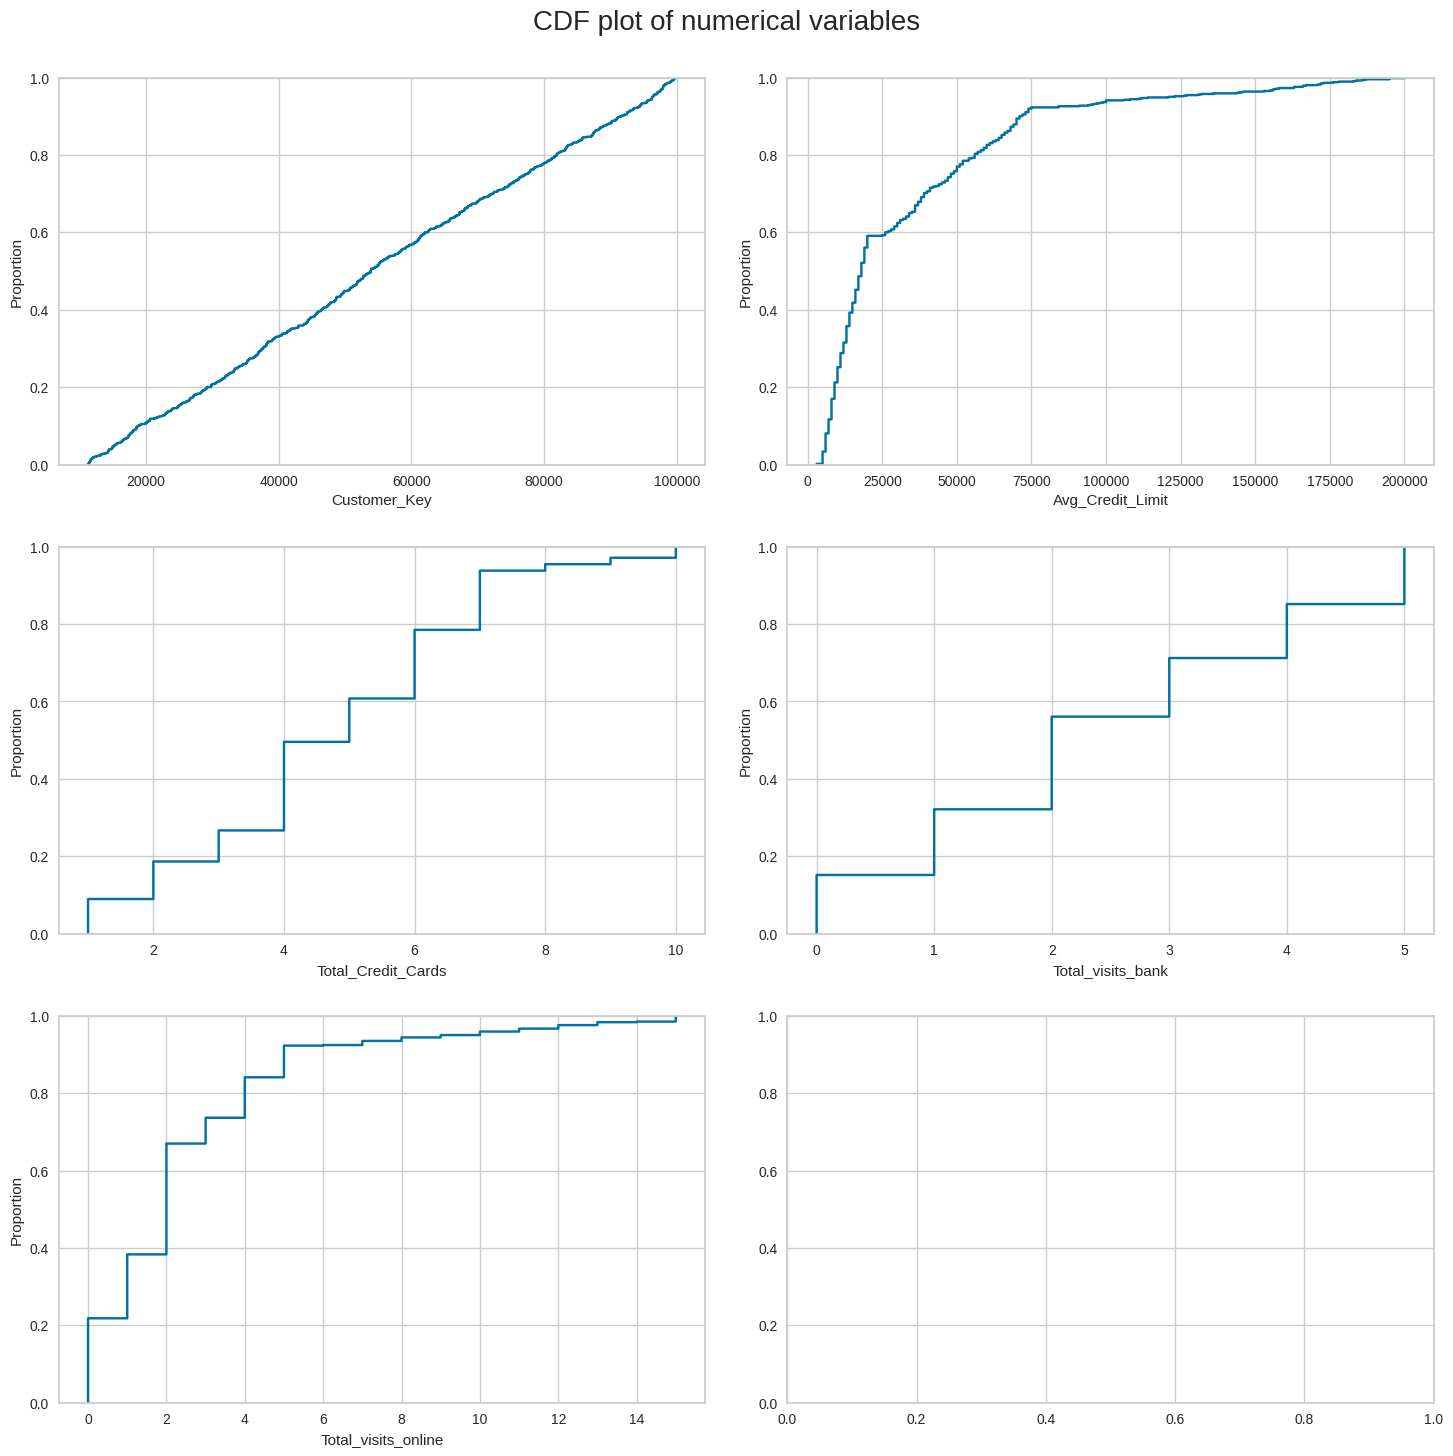

In [ ]:
#CDF Plot
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)

counter = 0

for ii in range(3):
    sns.ecdfplot(data=data, ax=axes[ii][0], x=data.columns.tolist()[counter])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(data=data, ax=axes[ii][1], x=data.columns.tolist()[counter])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)



*   The distribution for Total Credit cards and total bank visits were fairly even
*   The distribution for Average credit limit and total visits online were skewed to the right. More so for Avg credit limit than total visits online



### Bivariate Analysis

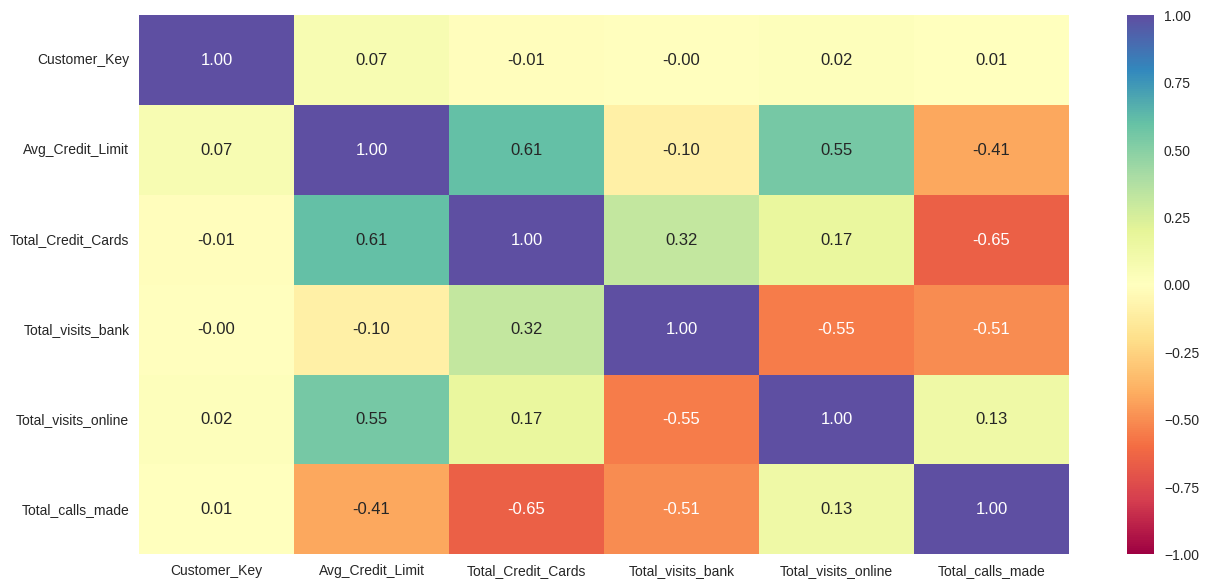

In [ ]:
#plot heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

*   Average credit limit and total credit cards were strongly correlated
*   Average credit limit and total visits online were also strongly correlated



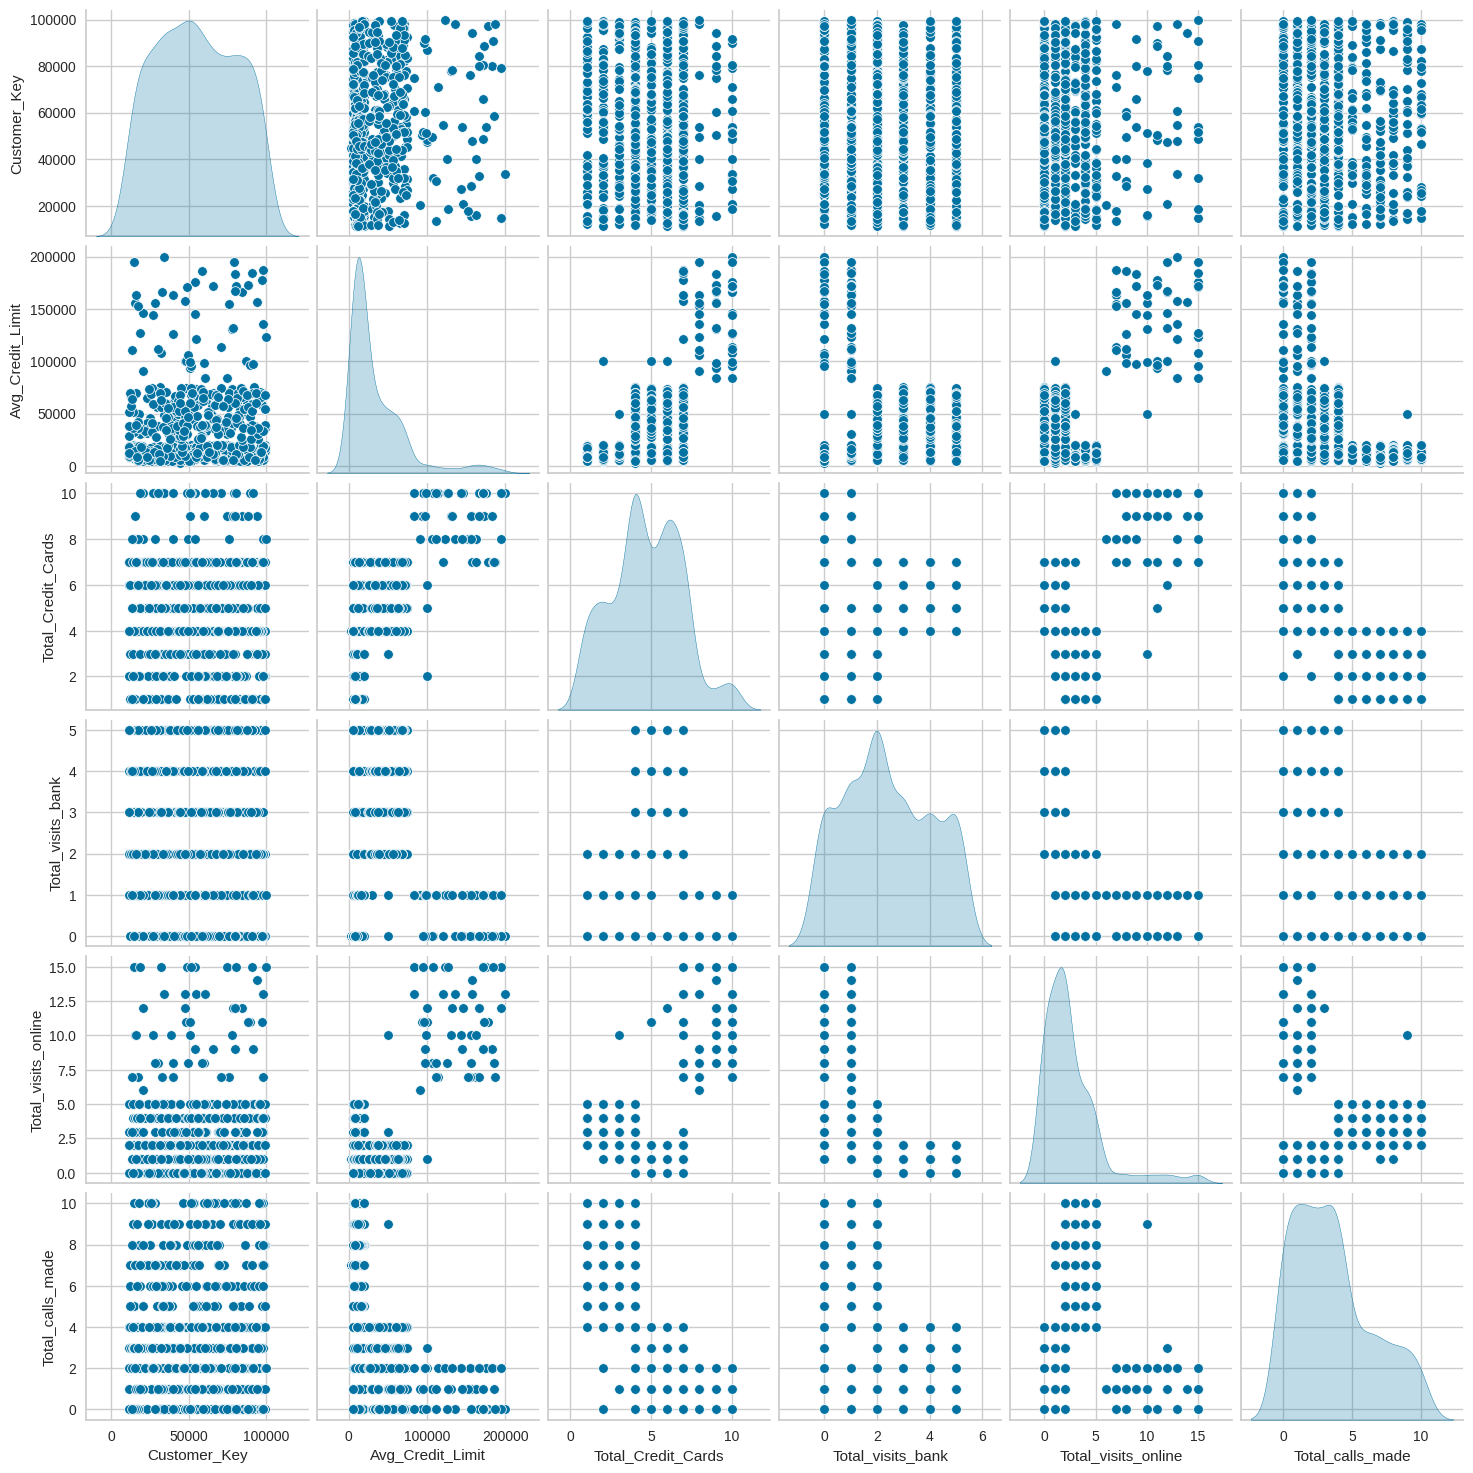

In [ ]:
#pairplot
sns.pairplot(data=data, diag_kind="kde")
plt.show()



*   Pairplot for all attributes against each other
*   This is excessive and unreadable. Redo with viable column pairs.






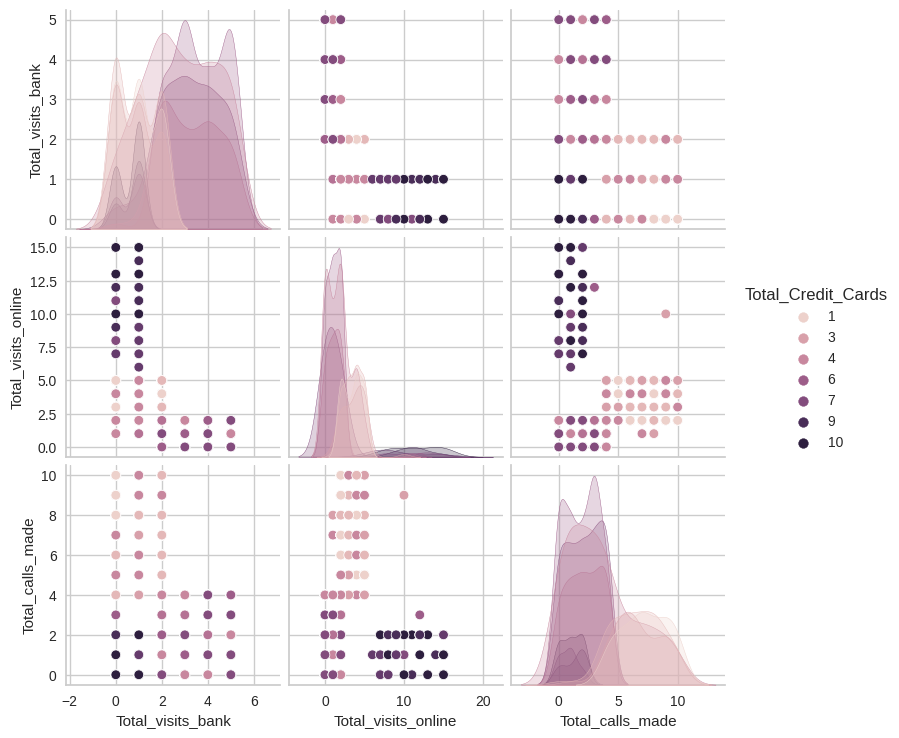

In [ ]:
sns.pairplot(
    data=data[
        [
            "Total_visits_bank",
            "Total_visits_online",
            "Total_calls_made",
            "Total_Credit_Cards",
        ]
    ],
    hue="Total_Credit_Cards",
)

plt.show()

*   Pair Plots are much better
*   Total Credit cards are correlated well with total visits online.



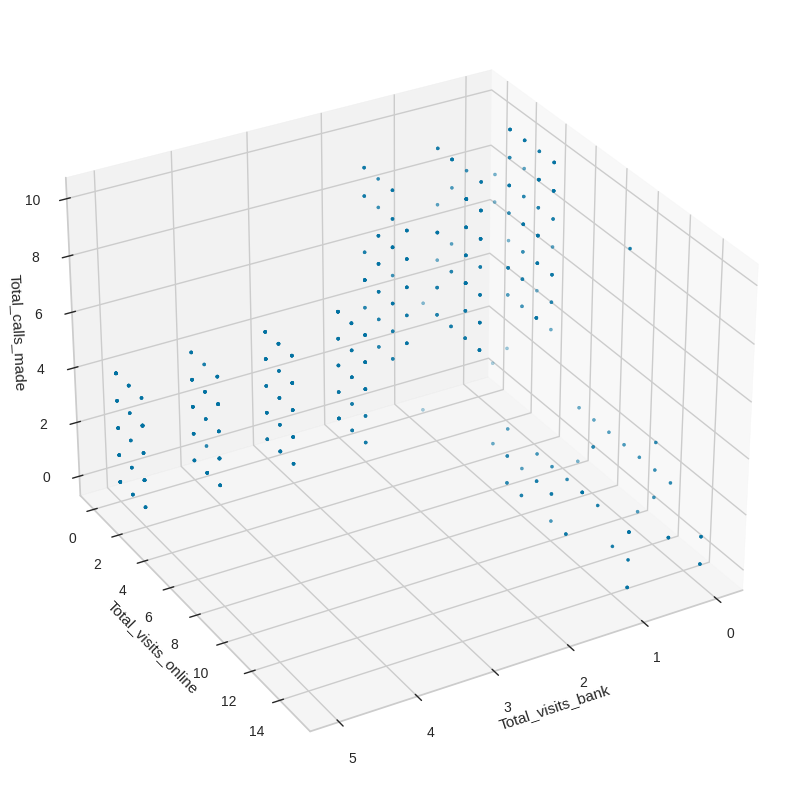

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")

x = data["Total_visits_bank"]
y = data["Total_visits_online"]
z = data["Total_calls_made"]


ax.scatter(x, y, z, marker=".")
ax.set_xlabel("Total_visits_bank")
ax.set_ylabel("Total_visits_online")
ax.set_zlabel("Total_calls_made")
ax.view_init(azim=60)
plt.show()

*   From the 3d projection we see that Total calls made and total visits online seemed to have the most correlation
*   Total bank visits did not seem to have any correlation



### Questions

1. How is the distrubution of average credit limit of customer?
2. What percenatage of the customers have never made a service-related call to the bank?
3. What percentage of customers have never logged in to the online portal?
4. How many customers have never visited bank?
3. How are the different variables correlated with each other?

In [ ]:
#percentage of customers that have never made a service-related call to the bank
num_no_calls = len(data[data['Total_calls_made'] == 0])
total_calls = len(data)

percentage = (num_no_calls / total_calls) * 100
print(percentage)

14.696969696969697


In [ ]:
num_no_online_visits = len(data[data['Total_visits_online'] == 0])
total_online_visits = len(data)
percentage = (num_no_online_visits / total_online_visits) * 100
print(percentage)

21.818181818181817


In [ ]:
num_no_bank_visits = len(data[data['Total_visits_bank'] == 0])
total_bank_visits = len(data)
percentage = (num_no_bank_visits / total_bank_visits) * 100
print(percentage)

15.151515151515152




1.  The distribution for Average_Credit_Limit for a customer is highly skewed to the right.
2.  Roughly 14.7% of all customers have never made a call to the bank
3.  Roughly 21.8% of all customers have never logged onto the online portal
4.  Roughly 15.2& of all customers have never visited a bank
5. The Variables that are correlated with each other are Avg_Credit_limit vs Credit_cards, and Avg_credit_limit vs number_visits_online



## Data Preprocessing



- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

### Duplicate Value Check

In [ ]:
#Completed in Sanity Checks of Data Overview

### Missing Value Treatment

In [ ]:
#there is no missing data
data.isnull().sum()

Customer_Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

### Outlier Detection

In [ ]:
#set threshold, find all outliers using z-scores
threshold = 3
outlier = {}
for col in data.columns:
    i = data[col]
    mean = np.mean(data[col])
    std = np.std(data[col])
    list1 = []
    for v in i:
        z = (v - mean) / std
        if z > threshold:
            list1.append(v)
    list1.sort()
    outlier[i.name] = list1

print("The following are the outliers in the data:")
for key, value in outlier.items():
    print("\n", key, ":", value)

The following are the outliers in the data:

 Customer_Key : []

 Avg_Credit_Limit : [153000, 155000, 156000, 156000, 157000, 158000, 163000, 163000, 166000, 166000, 167000, 171000, 172000, 172000, 173000, 176000, 178000, 183000, 184000, 186000, 187000, 195000, 195000, 200000]

 Total_Credit_Cards : []

 Total_visits_bank : []

 Total_visits_online : [12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

 Total_calls_made : []


### Scaling

In [ ]:
# scaling the data before clustering - scale avg credit limit and total visits online
scaler = StandardScaler()
subset = data[["Avg_Credit_Limit", "Total_visits_online"]]  ## Complete the code to scale the data
subset_scaled = scaler.fit_transform(subset)

In [ ]:
# creating a dataframe of the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

## K-means Clustering


### Checking elbow plot

In [ ]:
#make a copy of scaled subset data
k_means_df = subset_scaled_df.copy()

Number of Clusters: 2 	Average Distortion: 451.5834131039107
Number of Clusters: 3 	Average Distortion: 269.21329056544323
Number of Clusters: 4 	Average Distortion: 176.46896745600236
Number of Clusters: 5 	Average Distortion: 140.63328705779864
Number of Clusters: 6 	Average Distortion: 116.98531562497571
Number of Clusters: 7 	Average Distortion: 94.90335732206279
Number of Clusters: 8 	Average Distortion: 76.50096925014232
Number of Clusters: 9 	Average Distortion: 64.25518571234755
Number of Clusters: 10 	Average Distortion: 55.81048414016367


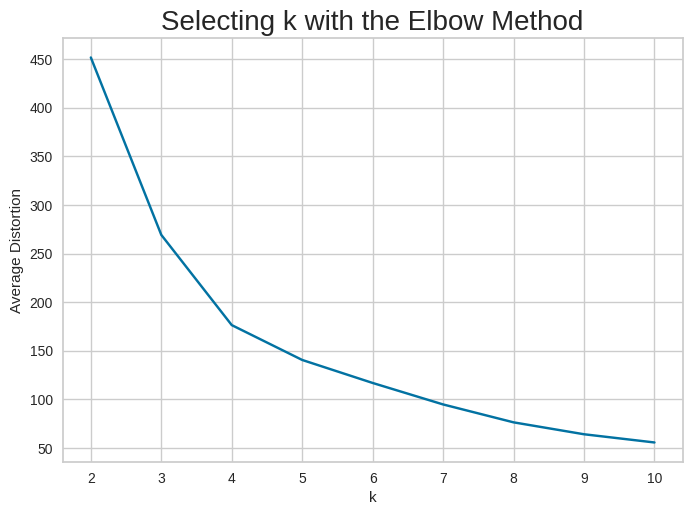

In [ ]:
#k-means clustering plotting.
#plot each cluster on an elbow plot
clusters = range(2, 11)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)
    prediction = model.predict(k_means_df)
    distortion = sum(
        np.min(cdist(k_means_df, model.cluster_centers_, "euclidean"), axis=1) ** 2)

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.show()

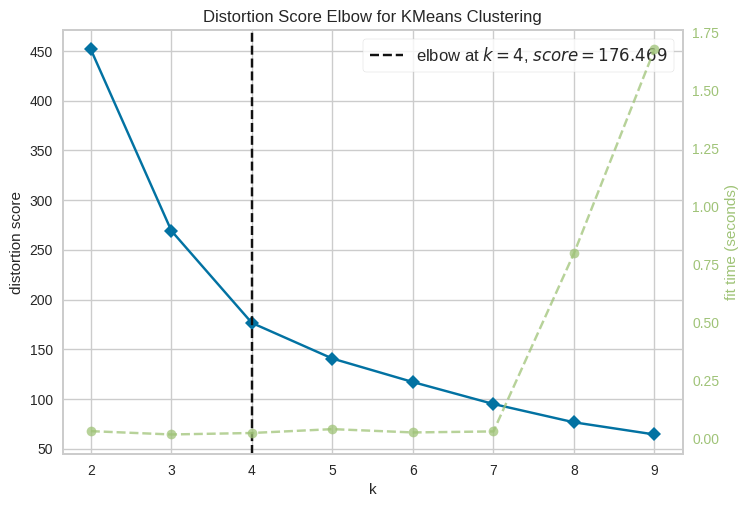

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#using imported visualizer to visualize elbow plot, render figure
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 10), timings=True)
visualizer.fit(k_means_df)
visualizer.show()

### Silhouette Scores

In [ ]:
#check silhouette scores for each clust23 2-9
sil_score = []
cluster_list = range(2, 10)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(k_means_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, the silhouette score is 0.7682497227534425)
For n_clusters = 3, the silhouette score is 0.4842911459073248)
For n_clusters = 4, the silhouette score is 0.5161938891198)
For n_clusters = 5, the silhouette score is 0.5027081498752822)
For n_clusters = 6, the silhouette score is 0.4863124147175233)
For n_clusters = 7, the silhouette score is 0.49137494349301236)
For n_clusters = 8, the silhouette score is 0.4968434041499755)
For n_clusters = 9, the silhouette score is 0.49853832690545385)


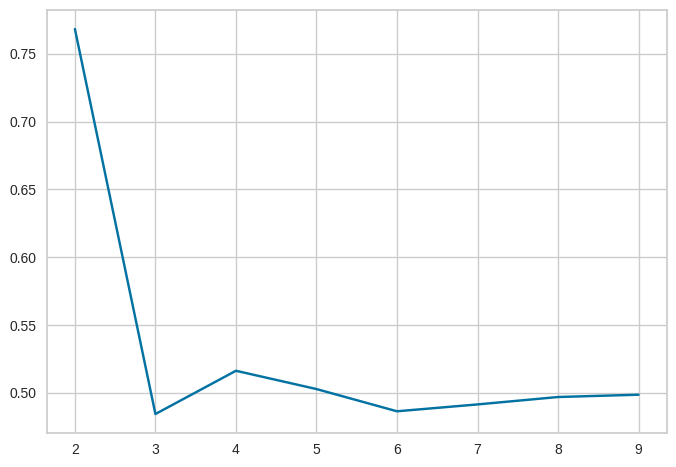

In [ ]:
#plot the scores of each cluster
plt.plot(cluster_list, sil_score)
plt.show()



*   We see a sharp drop between 2 and 3 clusters.
*   From 3-9, we do not see a drastic change in scores.



### Trying different number of clusters

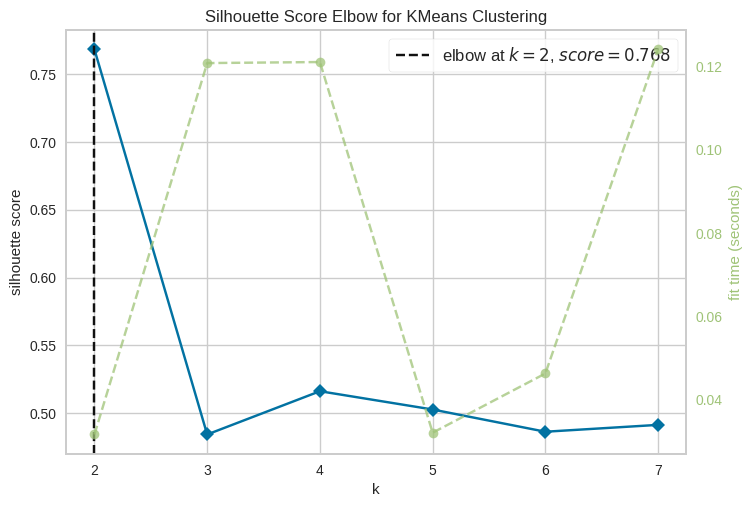

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 8), metric="silhouette", timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

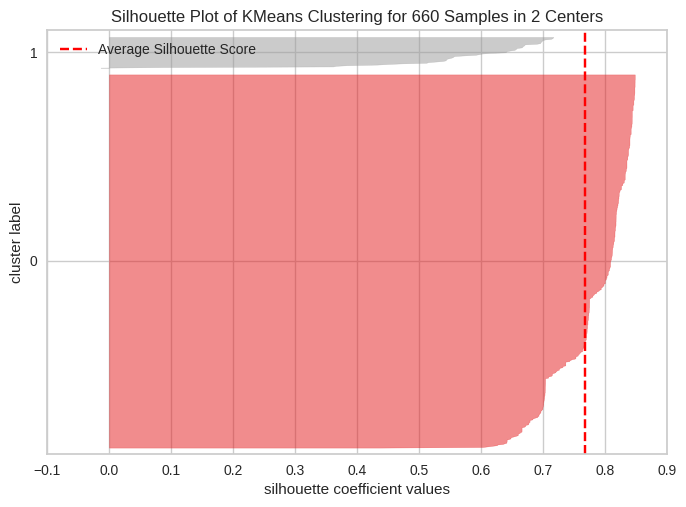

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

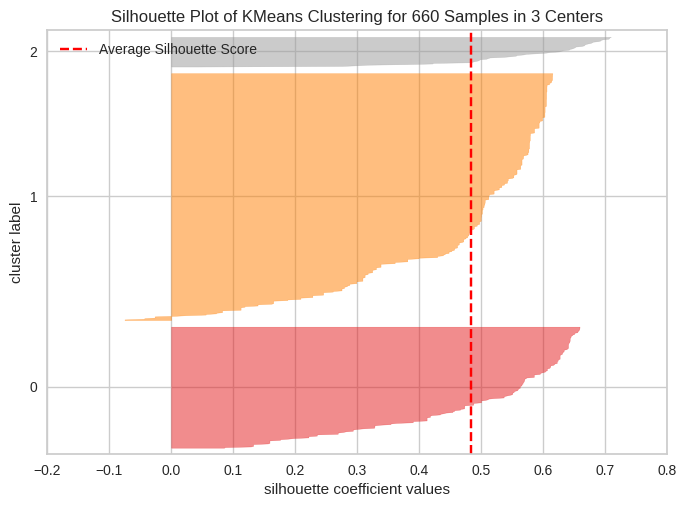

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

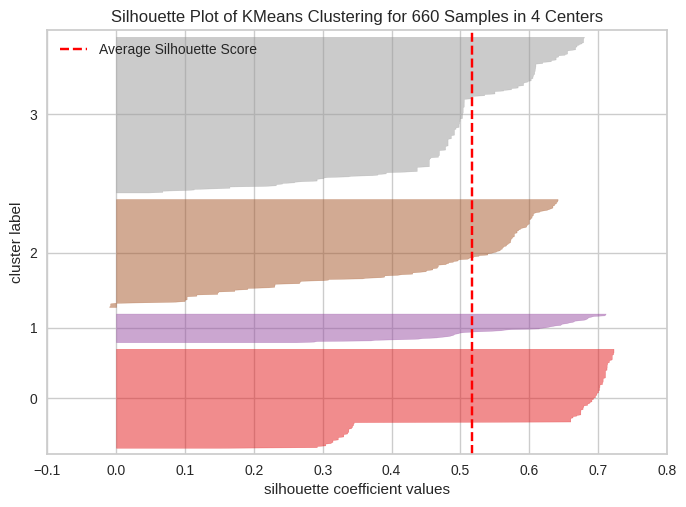

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

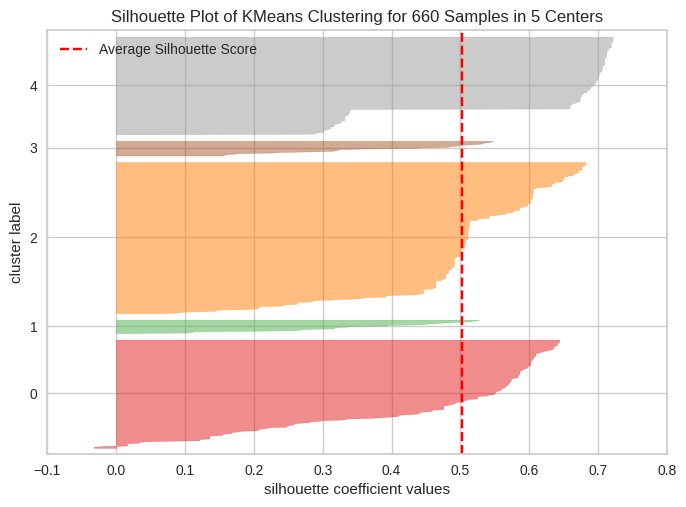

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

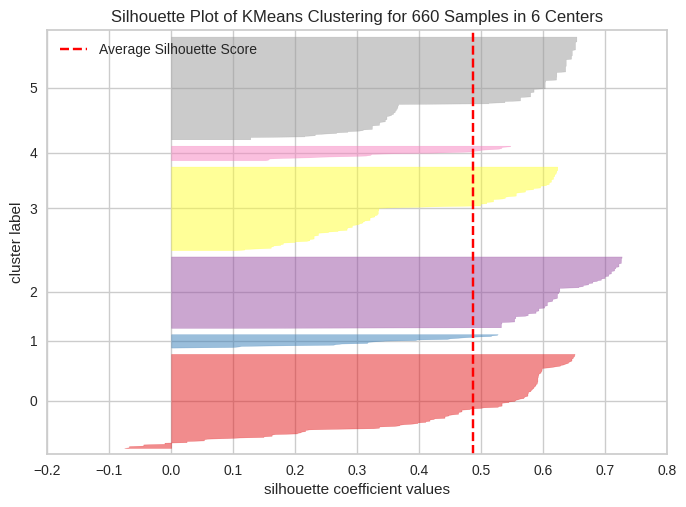

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

### Create Final Model

In [ ]:
%%time

kmeans = KMeans(n_clusters=2, random_state=1)
kmeans.fit(k_means_df)

CPU times: user 31.7 ms, sys: 778 µs, total: 32.4 ms
Wall time: 25.1 ms


KMeans(n_clusters=2, random_state=1)



*   2 Clusters is most optimal due to a big drop off when compared to 3 clusters in the elbow plot
*   2 clusters also yield the highest silhouette coefficient in the solhouette plots



In [ ]:
# creating a copy of the original data
df1 = data.copy()

# adding kmeans cluster labels to the original and scaled dataframes
k_means_df["K_means_segments"] = kmeans.labels_
df1["K_means_segments"] = kmeans.labels_

## Hierarchical Clustering

### Computing Cophenetic Correlation

In [ ]:
#make a copy
hc_df = subset_scaled_df.copy()

In [ ]:
#check the cophenetic coreelation of all distance metrics with all linkage methods

# list of distance metrics
distance_metrics = ['euclidean', 'chebyshev', 'mahalanobis', 'cityblock'] ## Complete the code to add distance metrics

# list of linkage methods
linkage_methods = ['single', 'complete', 'average', 'weighted'] ## Complete the code to add linkages

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hc_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(hc_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9007181487267775.
Cophenetic correlation for Euclidean distance and complete linkage is 0.918960124566038.
Cophenetic correlation for Euclidean distance and average linkage is 0.9267091777761204.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8934106898629317.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8902980303976954.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.9161513220719351.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9259753499349874.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9218532504584369.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8982454615451511.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.7465084590617549.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8966790236847257.
Cophenetic cor

In [ ]:
#find higheset combination of distance with linkage
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9267091777761204, which is obtained with Euclidean distance and average linkage.


In [ ]:
#do again with only euclidean for readability purposes
linkage_methods = ['single', 'complete', 'average', 'weighted']

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(hc_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(hc_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.9007181487267775.
Cophenetic correlation for complete linkage is 0.918960124566038.
Cophenetic correlation for average linkage is 0.9267091777761204.
Cophenetic correlation for weighted linkage is 0.8934106898629317.


In [ ]:
# Find highest linkage method of correlation of eucledean distance
print()
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)


Highest cophenetic correlation is 0.9267091777761204, which is obtained with average linkage.


### Check dendrograms

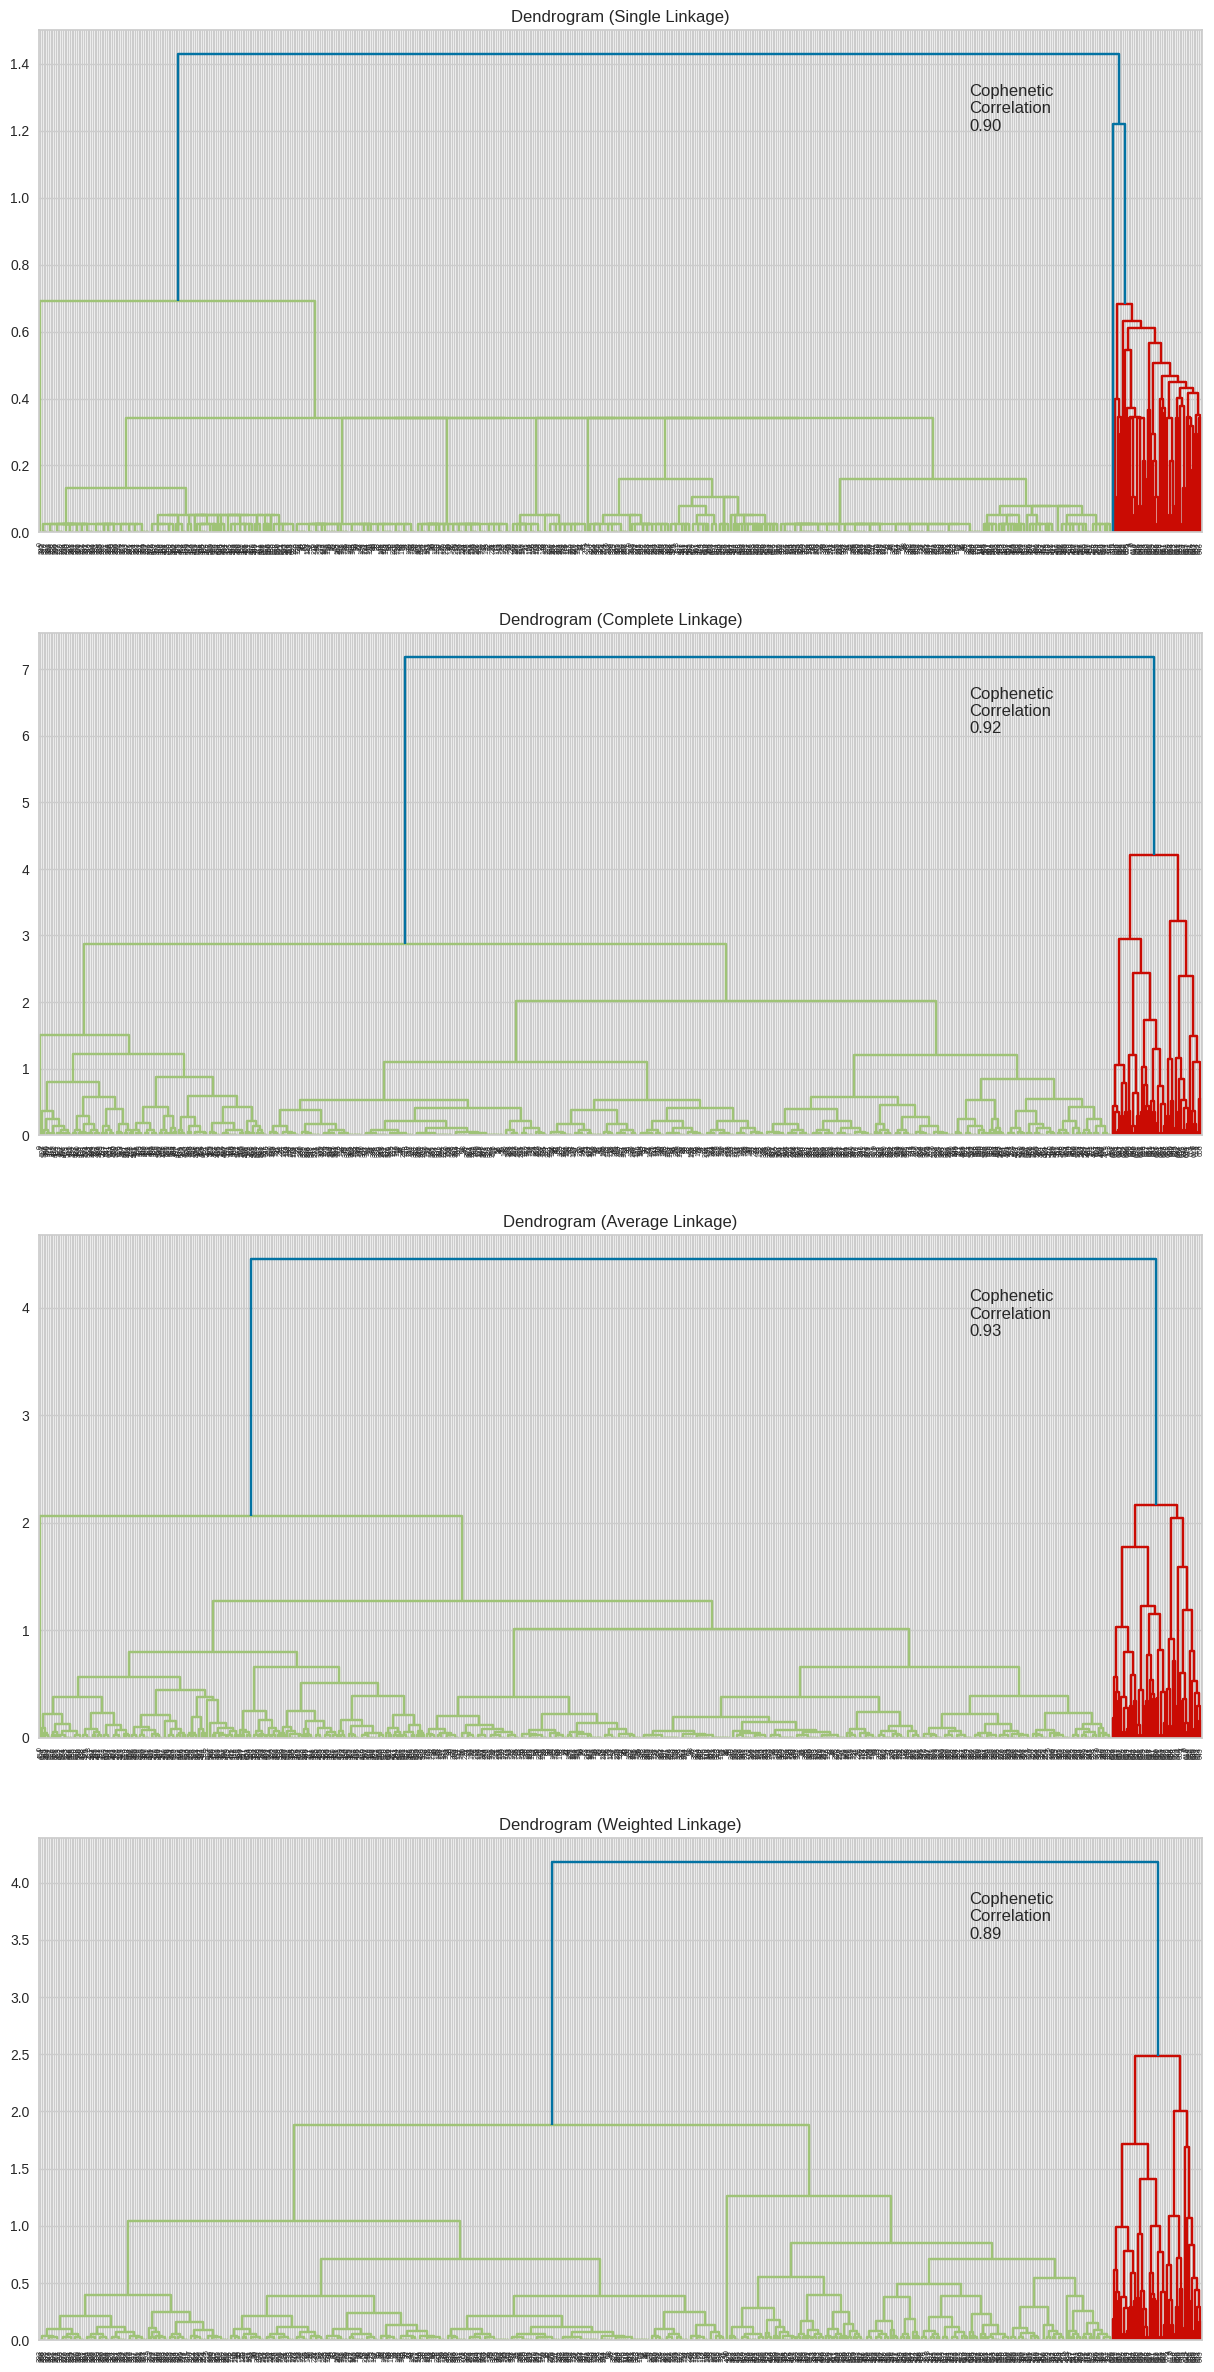

In [ ]:
# list of linkage methods
linkage_methods = ['single', 'complete', 'average', 'weighted']

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hc_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hc_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [ ]:
# Print these values in a data frame for readability
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

,Linkage,Cophenetic Coefficient
3,weighted,0.893411
0,single,0.900718
1,complete,0.918960
2,average,0.926709


### Create Final Model

In [ ]:
%%time

HCmodel = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')  ## Complete the code to define the hierarchical clustering model
HCmodel.fit(hc_df)

CPU times: user 17.1 ms, sys: 0 ns, total: 17.1 ms
Wall time: 50 ms


AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=3)

In [ ]:
# creating a copy of the original data
df2 = data.copy()

# adding hierarchical cluster labels to the original and scaled dataframes
hc_df["HC_segments"] = HCmodel.labels_
df2["HC_segments"] = HCmodel.labels_

In [ ]:
#check
hc_df.head()

,Avg_Credit_Limit,Total_visits_online,HC_segments
0,1.740187,-0.547490,0
1,0.410293,2.520519,1
2,0.410293,0.134290,0
3,-0.121665,-0.547490,0
4,1.740187,3.202298,1


In [ ]:
#check
df2.head()

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_segments
0,87073,100000,2,1,1,0,0
1,38414,50000,3,0,10,9,1
2,17341,50000,7,1,3,4,0
3,40496,30000,5,1,1,4,0
4,47437,100000,6,0,12,3,1


In [ ]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
data["HC_Clusters"] = HCmodel.labels_

## Cluster Profiling and Comparison

### Cluster profiling: K-means

In [ ]:
#group cluster labels for k-means
km_cluster_profile = df1.groupby("K_means_segments").mean()

In [ ]:
#count values for segments in k-means
km_cluster_profile["count_in_each_segment"] = (
    df1.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [ ]:
km_cluster_profile

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,,
0,55040.231527,25807.881773,4.377668,2.555008,1.912972,3.779967,609
1,56350.039216,139254.901961,8.627451,0.588235,10.882353,1.235294,51


### Cluster Profiling: Hierarchial

In [ ]:
#group cluster labels for Hierarchial
hc_cluster_profile = df2.groupby("HC_segments").mean()

In [ ]:
#count values for segments in Hierarchial, make dataframe profile
hc_cluster_profile["count_in_each_segment"] = (
    df2.groupby("HC_segments")["Avg_Credit_Limit"].count().values
)

In [ ]:
#print profile
hc_cluster_profile

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_segments,,,,,,,
0,55040.231527,25807.881773,4.377668,2.555008,1.912972,3.779967,609
1,52023.300000,100750.000000,8.650000,0.650000,10.700000,1.600000,20
2,59141.483871,164096.774194,8.612903,0.548387,11.000000,1.000000,31


## K-means vs Hierarchical Clustering

You compare several things, like:
- Which clustering technique took less time for execution?
- Which clustering technique gave you more distinct clusters, or are they the same?
- How many observations are there in the similar clusters of both algorithms?
- How many clusters are obtained as the appropriate number of clusters from both algorithms?

You can also mention any differences or similarities you obtained in the cluster profiles from both the clustering techniques.

In [ ]:
#print km_profile with style added
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,,
0,55040.231527,25807.881773,4.377668,2.555008,1.912972,3.779967,609
1,56350.039216,139254.901961,8.627451,0.588235,10.882353,1.235294,51


In [ ]:
#print hc_profile with style added
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_segments,,,,,,,
0,55040.231527,25807.881773,4.377668,2.555008,1.912972,3.779967,609
1,52023.300000,100750.000000,8.650000,0.650000,10.700000,1.600000,20
2,59141.483871,164096.774194,8.612903,0.548387,11.000000,1.000000,31


<Axes: xlabel='K_means_segments'>

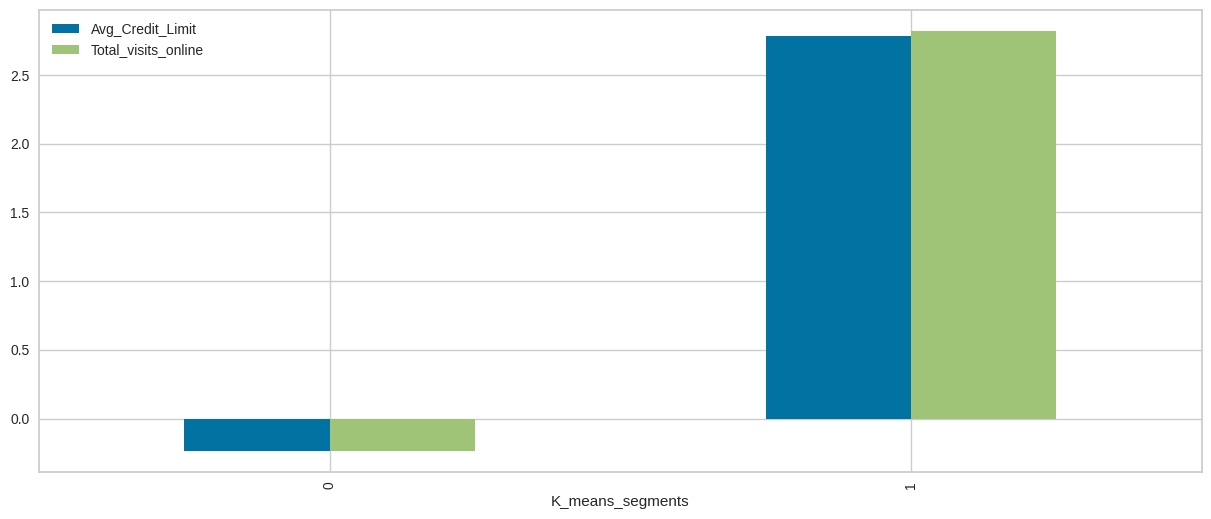

In [ ]:
#barplot for k_means
k_means_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

<Axes: xlabel='HC_segments'>

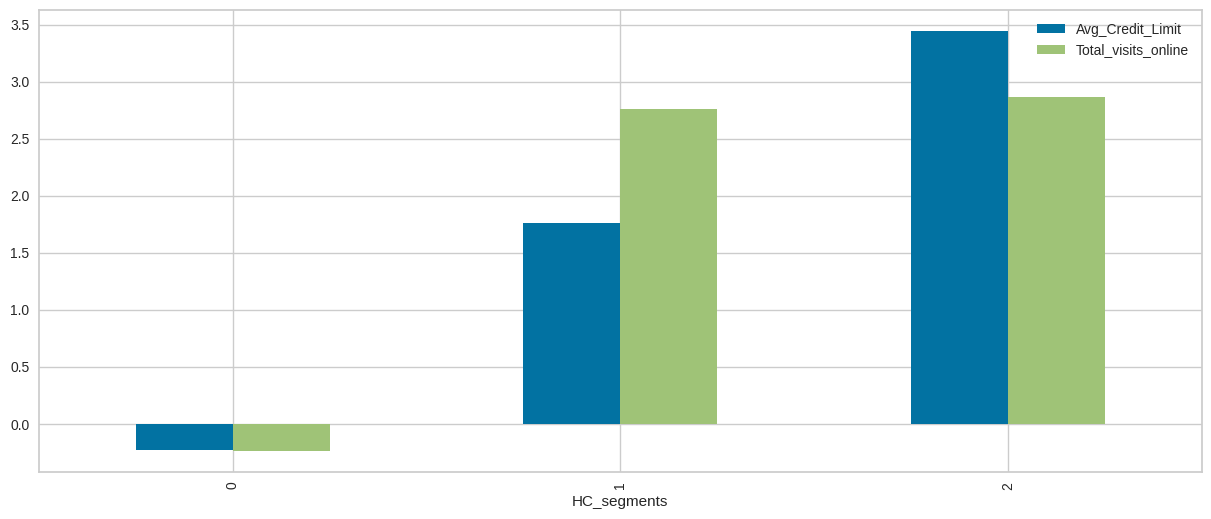

In [ ]:
#barplot for Hierarchial
hc_df.groupby("HC_segments").mean().plot.bar(figsize=(15, 6))

In [ ]:
k_means_df.loc[k_means_df["K_means_segments"] == 1, "K_means_segments"] = 3
k_means_df.loc[k_means_df["K_means_segments"] == 2, "K_means_segments"] = 1
k_means_df.loc[k_means_df["K_means_segments"] == 3, "K_means_segments"] = 2
df1["K_means_segments"] = k_means_df["K_means_segments"]

km_cluster_profile = df1.groupby("K_means_segments").mean()
km_cluster_profile["count_in_each_segment"] = (
    df1.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [ ]:
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,,
0,55040.231527,25807.881773,4.377668,2.555008,1.912972,3.779967,609
2,56350.039216,139254.901961,8.627451,0.588235,10.882353,1.235294,51


<Axes: xlabel='K_means_segments'>

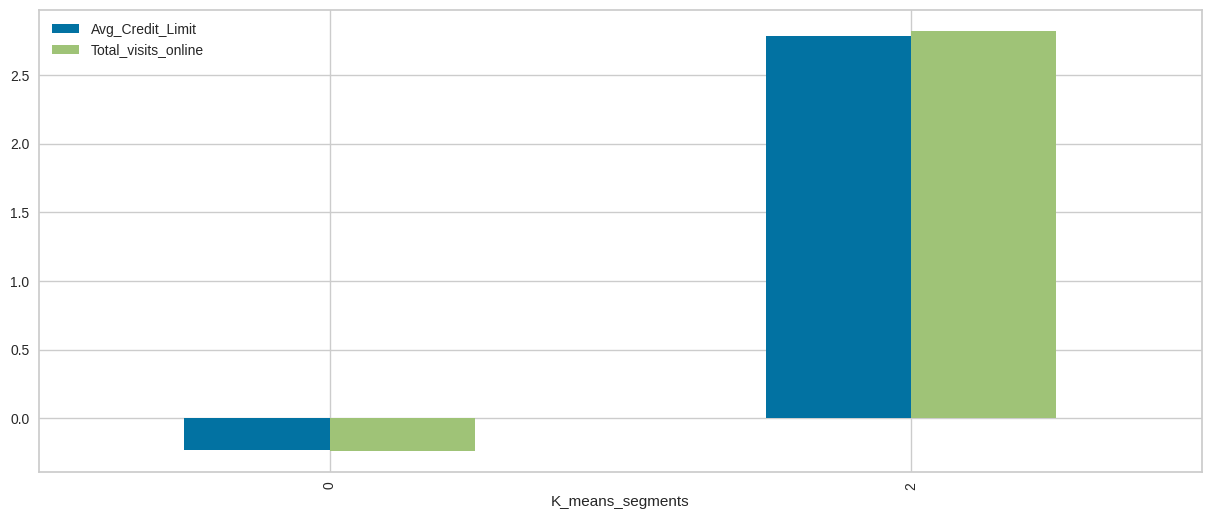

In [ ]:
k_means_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

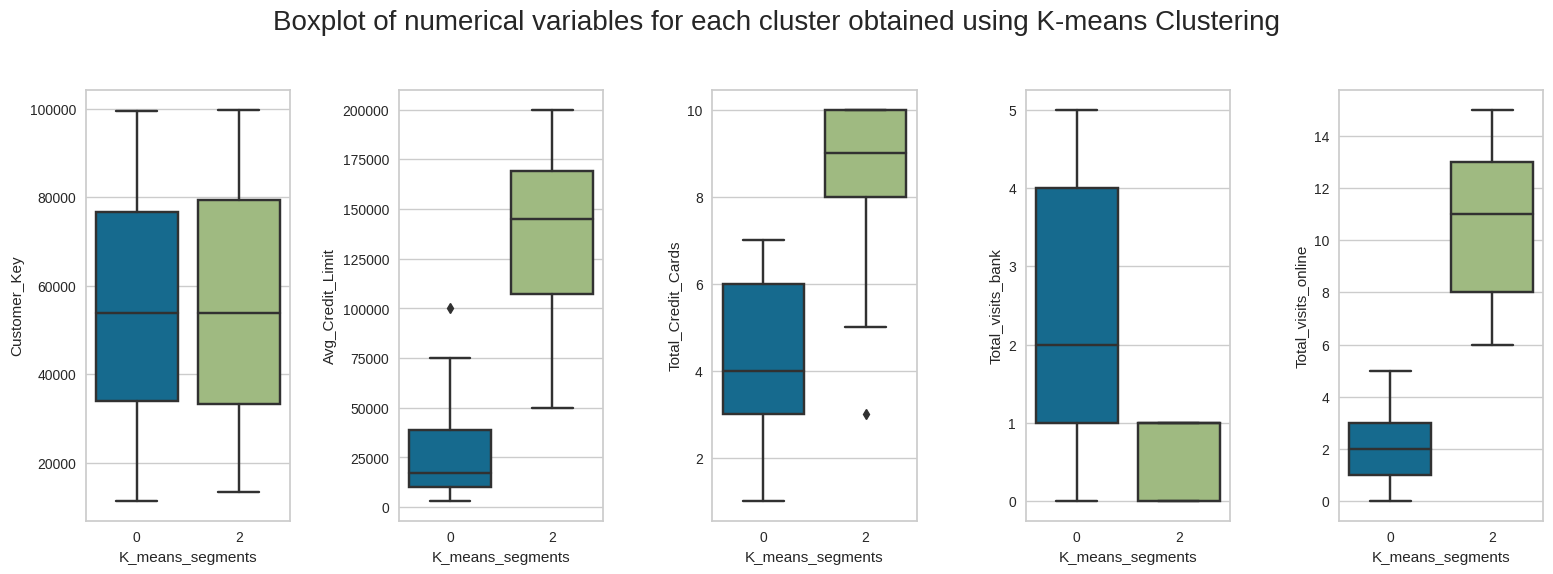

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle(
    "Boxplot of numerical variables for each cluster obtained using K-means Clustering",
    fontsize=20,
)

counter = 0

for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df1[df1.columns[counter]], x=k_means_df["K_means_segments"]
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

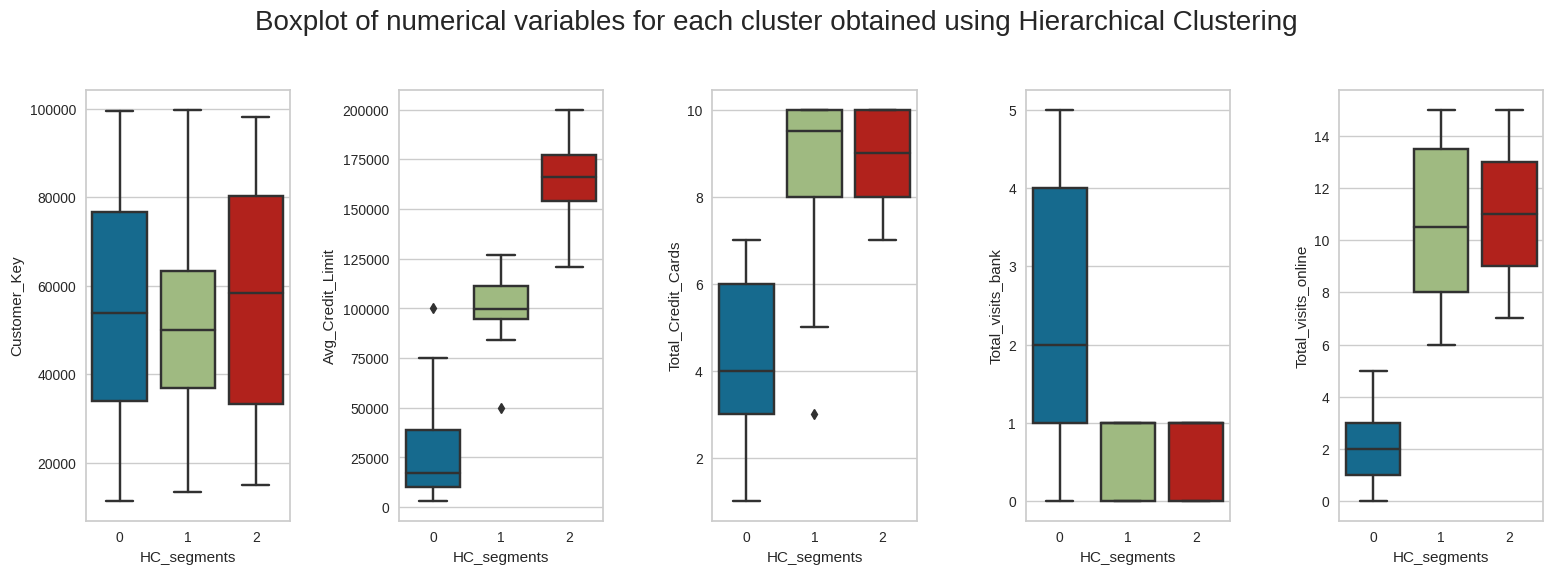

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle(
    "Boxplot of numerical variables for each cluster obtained using Hierarchical Clustering",
    fontsize=20,
)

counter = 0

for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df2[df2.columns[counter]], x=hc_df["HC_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

*   K-Means Clustering took a total wall time of 25.1 ms, while Hierarchial Clustering took a total wall time of 50  ms.
*    In general, K-means clustering tends to be faster than Hierarchial clustering
*   Hierarchial Clustering gave 3 distinct clusters, whereas K-means clustering gave 2 distinct clusters
*   There are 609 observations in similar clusters of both groups. This represents 92% of all observations
*   The 0-Group of both clustering algorithms were both properly clustered, giviing similar results.





## Actionable Insights and Recommendations

*   Based on the Exploratory Data Analysis, the variables that are correlated with each other are Avg_Credit_limit vs Credit_cards, and Avg_credit_limit vs number_visits_online.
*   Avg_Credit_limit was more correlated with number_visits_online than it was with number_bank_visits, meaning that more customers interact online rather than in person when it comes to solving issues. The bank should focus its problem solving efforts on smooth application interaction, UI/UX, and readily available call centers for customers to quickly resolve issues.
*   Making many in-person services such as deposits, withdrawls, and payments into online services would maximize customer retention.
*   In both cases of clustering, the high priority customers (or large spenders) only make up around 10% of the dataset. Those are also the customers who have very high number_visits_online.
*   The proper approach is to target the 92% cluster of customers who have low number_visits_online and encourage them with online promotions, turning them into online customers






In [ ]:
%%shell
jupyter nbconvert --to html ///content/Daniel_Lien_SLC_Full_Code.ipynb

[NbConvertApp] WARNING | pattern '///content/Daniel_Lien_SLC_Full_Code.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answe

CalledProcessError: ignored

___